In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
from function_interpolate_1theodolite import process_lidar_1theodolite
from function_interpolate_2theodolites import process_lidar_2theodolite
import seaborn as sns
import os
from function_calculation_altitude_from_wxt import process_altitude

## Create combined Lidar files

In [2]:
# create a combined file for Lidar data on 2025-08-27
'''
files = ["20250827_080000.nc", "20250827_090000.nc", "20250827_100000.nc", "20250827_110000.nc"]

folder = "Data_Lidar/20250827"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250827/combined_20250827.nc")
'''

'\nfiles = ["20250827_080000.nc", "20250827_090000.nc", "20250827_100000.nc", "20250827_110000.nc"]\n\nfolder = "Data_Lidar/20250827"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250827/combined_20250827.nc")\n'

In [3]:
# create a combined file for Lidar data on 2025-09-01
'''
files = ["20250901_090000.nc", "20250901_100000.nc", "20250901_110000.nc", "20250901_120000.nc", "20250901_130000.nc", "20250901_140000.nc"]

folder = "Data_Lidar/20250901"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250901/combined_20250901.nc")
'''

'\nfiles = ["20250901_090000.nc", "20250901_100000.nc", "20250901_110000.nc", "20250901_120000.nc", "20250901_130000.nc", "20250901_140000.nc"]\n\nfolder = "Data_Lidar/20250901"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250901/combined_20250901.nc")\n'

In [4]:
# create a combined file for Lidar data on 2025-09-03
'''
files = ["20250903_080000.nc", "20250903_090000.nc", "20250903_100000.nc", "20250903_110000.nc", "20250903_120000.nc", "20250903_130000.nc", "20250903_140000.nc", "20250903_150000.nc"]

folder = "Data_Lidar/20250903"
file_paths = [os.path.join(folder, f) for f in files]

# Öffnen und automatisch entlang der Dimension "time" kombinieren
ds = xr.open_mfdataset(file_paths, combine='by_coords')

# Ergebnis als neues NetCDF speichern
ds.to_netcdf("Data_Lidar/20250903/combined_20250903.nc")
'''

'\nfiles = ["20250903_080000.nc", "20250903_090000.nc", "20250903_100000.nc", "20250903_110000.nc", "20250903_120000.nc", "20250903_130000.nc", "20250903_140000.nc", "20250903_150000.nc"]\n\nfolder = "Data_Lidar/20250903"\nfile_paths = [os.path.join(folder, f) for f in files]\n\n# Öffnen und automatisch entlang der Dimension "time" kombinieren\nds = xr.open_mfdataset(file_paths, combine=\'by_coords\')\n\n# Ergebnis als neues NetCDF speichern\nds.to_netcdf("Data_Lidar/20250903/combined_20250903.nc")\n'

## Calculate altitude of kite

In [5]:
# function to calculate the height from the pressure, with hydrostatic approximation
def height_from_pressure(p2, p1=1007,rho=1.15, g=9.81):
    dp = p1 - p2
    dz = dp / (rho * g)
    return dz

In [6]:
# 2025-08-27
'''
process_altitude(
    date_str="2025-08-27",
    ptu_file="Data_Radiosonde/PtuResults.xlsx",
    wxt_file="Data_WXT/20250827.txt",
    lidar_file="Data_Lidar/20250827/combined_20250827.nc",
    output_csv="Data_Altitude/20250827_altitude_kite_from_wxt_funct.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-08-27",\n    ptu_file="Data_Radiosonde/PtuResults.xlsx",\n    wxt_file="Data_WXT/20250827.txt",\n    lidar_file="Data_Lidar/20250827/combined_20250827.nc",\n    output_csv="Data_Altitude/20250827_altitude_kite_from_wxt_funct.csv"\n)\n'

In [7]:
# 2025-08-29
'''
ds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250829/combined_20250829.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",
    date_str="2025-08-29",
    start_time_str="08:31:08",
    azimuth_offsetRot= 129.1787,
    azimuth_offsetGelb= 51.8498
)

alt_0829 = np.sin(np.deg2rad(theo_interp_0829['elevation'])) * 87.56
df_alt_cont = pd.DataFrame({
    "time": ds_lidar_cut_0829['time'],
    "altitude": np.array(alt_0829)
})

df_alt_cont.to_csv("Data_Altitude/20250829_altitude_kite_from_tetherlength.csv", index=False)
'''

'\nds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(\n    lidar_file="Data_Lidar/20250829/combined_20250829.nc",\n    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",\n    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",\n    date_str="2025-08-29",\n    start_time_str="08:31:08",\n    azimuth_offsetRot= 129.1787,\n    azimuth_offsetGelb= 51.8498\n)\n\nalt_0829 = np.sin(np.deg2rad(theo_interp_0829[\'elevation\'])) * 87.56\ndf_alt_cont = pd.DataFrame({\n    "time": ds_lidar_cut_0829[\'time\'],\n    "altitude": np.array(alt_0829)\n})\n\ndf_alt_cont.to_csv("Data_Altitude/20250829_altitude_kite_from_tetherlength.csv", index=False)\n'

In [8]:
# 2025-09-01
'''
process_altitude(
    date_str="2025-09-01",
    ptu_file="Data_Radiosonde/20250901/PtuResults.xlsx",
    wxt_file="Data_WXT/20250901.txt",
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    output_csv="Data_Altitude/20250901_altitude_kite_from_wxt.csv"
)
'''

'\nprocess_altitude(\n    date_str="2025-09-01",\n    ptu_file="Data_Radiosonde/20250901/PtuResults.xlsx",\n    wxt_file="Data_WXT/20250901.txt",\n    lidar_file="Data_Lidar/20250901/combined_20250901.nc",\n    output_csv="Data_Altitude/20250901_altitude_kite_from_wxt.csv"\n)\n'

In [9]:
# 2025-09-03, 1st period
process_altitude(
    date_str="2025-09-03",
    ptu_file="Data_Radiosonde/20250903/PtuResults_1stperiod.xlsx",
    wxt_file="Data_WXT/20250903.txt",
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    output_csv="Data_Altitude/20250903_1stperiod_altitude_kite_from_wxt.csv"
)

Altitude data saved to Data_Altitude/20250903_1stperiod_altitude_kite_from_wxt.csv


In [10]:
# 2025-09-03, 2nd period
process_altitude(
    date_str="2025-09-03",
    ptu_file="Data_Radiosonde/20250903/PtuResults_2ndperiod.xlsx",
    wxt_file="Data_WXT/20250903.txt",
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    output_csv="Data_Altitude/20250903_2ndperiod_altitude_kite_from_wxt.csv"
)

Altitude data saved to Data_Altitude/20250903_2ndperiod_altitude_kite_from_wxt.csv


## Read data

In [11]:
# read data 2025-08-27
ds_lidar_cut, theo_interp = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250827/20250827_090000.nc",
    theo_file="Data_Theodolite/TheoRot_20250827_150544.txt",
    date_str="2025-08-27",
    start_time_str="09:08:09",
    azimuth_offset= 107.46
)

Metadata: S 25/08/27 09:08:09


In [12]:
# cut out the valid periods for day 2025-08-27
valid1 = datetime(2025, 8, 27, 9, 21, 0)  # 2025-08-27 11:21:00
valid2 = datetime(2025, 8, 27, 9, 39, 0)  # 2025-08-27 11:39:00
valid3 = datetime(2025, 8, 27, 9, 45, 0)  # 2025-08-27 11:45:00
valid4 = datetime(2025, 8, 27, 9, 53, 0)  # 2025-08-27 11:53:00

VEL_27_09_1 = ds_lidar_cut.sel(time=slice(valid1, valid2))
VEL_27_09_2 = ds_lidar_cut.sel(time=slice(valid3, valid4))
theo_27_09_1 = theo_interp.sel(time=slice(valid1, valid2))
theo_27_09_2 = theo_interp.sel(time=slice(valid3, valid4))

In [13]:
# read data 2025-08-29
ds_lidar_cut_0829, theo_interp_0829 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250829/combined_20250829.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250829_123352.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250829_124013.txt",
    date_str="2025-08-29",
    start_time_str="08:31:08",
    azimuth_offsetRot= 129.1787,
    azimuth_offsetGelb= 51.8498
)

Metadata: S 25/08/29 08:31:09
Metadata: S 25/08/29 08:31:08


In [14]:
# read data 2025-09-01
# STILL ADD THE AZIMUTH CORRECTIONS!!!
ds_lidar_cut_0901_period1, theo_interp_0901_period1 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250901_1st_period.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250901_1st_period.txt",
    date_str="2025-09-01",
    start_time_str="09:03:20",
    azimuth_offsetRot= 0.0,
    azimuth_offsetGelb= 0.0
)
ds_lidar_cut_0901_period2, theo_interp_0901_period2 = process_lidar_2theodolite(
    lidar_file="Data_Lidar/20250901/combined_20250901.nc",
    theoRot_file="Data_Theodolite/TheoRot_20250901_2nd_period.txt",
    theoGelb_file="Data_Theodolite/TheoGelb_20250901_2nd_period.txt",
    date_str="2025-09-01",
    start_time_str="12:17:09",
    azimuth_offsetRot= 0.0,
    azimuth_offsetGelb= 0.0
)

Metadata: S 25/09/01 09:03:20
Metadata: S 25/09/01 09:03:20
Metadata: S 25/09/01 12:17:09
Metadata: S 25/09/01 12:17:08


In [15]:
# read data 2025-09-03
# STILL ADD THE AZIMUTH CORRECTIONS!!!
ds_lidar_cut_0903_period1, theo_interp_0903_period1 = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    theo_file="Data_Theodolite/TheoGelb_20250903_1stperiod.txt",
    date_str="2025-09-03",
    start_time_str="08:48:09",
    azimuth_offset= 0.0
)

ds_lidar_cut_0903_period2, theo_interp_0903_period2 = process_lidar_1theodolite(
    lidar_file="Data_Lidar/20250903/combined_20250903.nc",
    theo_file="Data_Theodolite/TheoGelb_20250903_2ndperiod.txt",
    date_str="2025-09-03",
    start_time_str="12:42:17",
    azimuth_offset= 0.0
)

Metadata: S 25/09/03 08:48:09
Metadata: S 25/09/03 12:42:17


In [16]:
# plot altitude from hydrostatic approximation
'''
fig = plt.figure()
plt.plot(df_ptu[1:3683].index,height_from_pressure(df_ptu['Pressure'][1:3683])*100, '.-',markersize=0.5, label = r'$p_0$ = 1007 hPa')
plt.plot(df_min['Time'][:61],altitude_cont*100, '.-', color='red',label = r'$p_0$ = p(WXT station)')
plt.xlim(df_min['Time'][0], df_min['Time'][61])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.ylim(0,100)
plt.title(r'Kite altitude calculated from hydrostatic equation, 2025-08-27')
plt.ylabel('Altitude above reference level (m)')
plt.xlabel('Time (UTC)')
plt.legend()
plt.show()
fig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)
'''

"\nfig = plt.figure()\nplt.plot(df_ptu[1:3683].index,height_from_pressure(df_ptu['Pressure'][1:3683])*100, '.-',markersize=0.5, label = r'$p_0$ = 1007 hPa')\nplt.plot(df_min['Time'][:61],altitude_cont*100, '.-', color='red',label = r'$p_0$ = p(WXT station)')\nplt.xlim(df_min['Time'][0], df_min['Time'][61])\nplt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))\nplt.ylim(0,100)\nplt.title(r'Kite altitude calculated from hydrostatic equation, 2025-08-27')\nplt.ylabel('Altitude above reference level (m)')\nplt.xlabel('Time (UTC)')\nplt.legend()\nplt.show()\nfig.savefig('Plots/20250827_Radiosonde_altitude.png', dpi=300)\n"

## Boxplot

In [17]:
### ---- Define parameters here -------
height_value = 60 # m
bin_size = 5 # deg
### create dataframes of each measurement period
df1 = pd.DataFrame({
    'elevation': theo_27_09_1['elevation'].values,
    'wind_speed': VEL_27_09_1['VEL'].sel(height=height_value).values
})
df2 = pd.DataFrame({
    'elevation': theo_27_09_2['elevation'].values,
    'wind_speed': VEL_27_09_2['VEL'].sel(height=height_value).values
})

df3 = pd.DataFrame({
    'elevation': theo_interp_0829['elevation'].values,
    'wind_speed': ds_lidar_cut_0829['VEL'].sel(height=height_value).values
})

df4 = pd.DataFrame({
    'elevation': theo_interp_0901_period1['elevation'].values,
    'wind_speed': ds_lidar_cut_0901_period1['VEL'].sel(height=height_value).values
})

df5 = pd.DataFrame({
    'elevation': theo_interp_0901_period2['elevation'].values,
    'wind_speed': ds_lidar_cut_0901_period2['VEL'].sel(height=height_value).values
})

df6 = pd.DataFrame({
    'elevation': theo_interp_0903_period1['elevation'].values,
    'wind_speed': ds_lidar_cut_0903_period1['VEL'].sel(height=height_value).values
})

df7 = pd.DataFrame({
    'elevation': theo_interp_0903_period2['elevation'].values,
    'wind_speed': ds_lidar_cut_0903_period2['VEL'].sel(height=height_value).values
})

### just add more dataframes for more days/measurement periods

# Combine all
df_all = pd.concat([df1, df2, df3, df4, df5, df6, df7], ignore_index=True)


In [18]:
bins = np.arange(0, 91, bin_size)
labels = [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(len(bins)-1)] ### pretty labels

# Elevation in bins
df_all['elev_bin'] = pd.cut(df_all['elevation'], bins=bins, labels=labels, include_lowest=True)

/var/folders/k6/y7fg0_p51yj9myt7l79bb1mc0000gn/T/ipykernel_6663/3422592105.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = df_all.groupby('elev_bin').size()


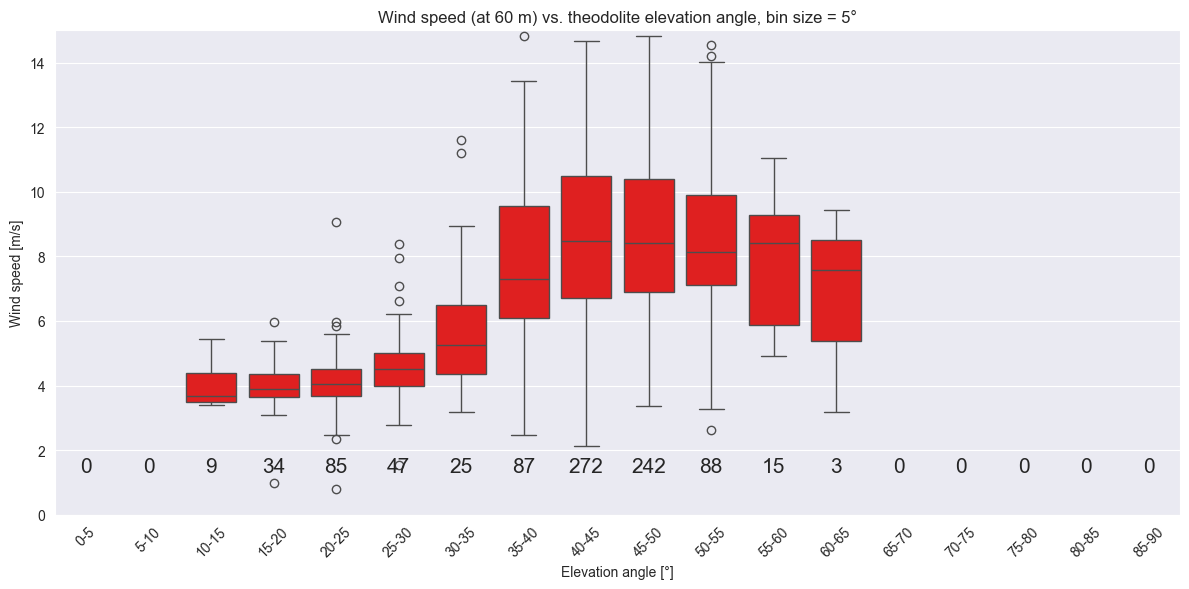

In [21]:
fig = plt.figure(figsize=(12,6))
sns.boxplot(x='elev_bin', y='wind_speed', data=df_all, color='r')

plt.xlabel('Elevation angle [°]')
plt.ylabel('Wind speed [m/s]')
plt.title(f'Wind speed (at {height_value} m) vs. theodolite elevation angle, bin size = {bin_size}°')
plt.xticks(rotation=45)
plt.ylim(0, 15)

# Show data points per bin
counts = df_all.groupby('elev_bin').size()
ax = plt.gca()
for i, bin_label in enumerate(labels):
    ax.text(i, 1.2, str(counts.get(bin_label,0)), ha='center', va='bottom', fontsize=15)

plt.tight_layout()
plt.show()
fig.savefig("Plots/boxplot_ws_elv_60m5deg_final.png", dpi=300)
